# Sentiment Analysis in English
***
## Table of Contents
1. [Introduction](#1-introduction)
1. [Device Agnostic Code](#2-device-agnostic-code)
1. [Loading Data](#3-loading-data)
1. [Data Preprocessing](#4-data-preprocessing)
    - [Text Cleaning](#text-cleaning)
    - [Tokenisation](#tokenisation)
    - [Building Vocabulary and Mapping Tokens to Indices](#building-vocabulary-and-mapping-tokens-to-indices)
    - [Convert Labels to Integer](#convert-labels-to-integer)
1. [Preparing DataLoaders](#5-preparing-dataloaders)
    - [Train Test Splitting](#train-test-splitting)
    - [Create IMDB Datasets in Tensor](#creating-imdb-datasets-in-tensor)
1. [Neural Network Model Architectures](#6-neural-network-model-architectures)
    - [Long Short-Term Memory (LSTM)](#long-short-term-memory-lstm)
    - [Transformer](#transformer)
1. [Evaluation Metrics](#7-evaluation-metrics)
    - [Accuracy](#accuracy)
1. [Loss Function](#8-loss-function)
    - [Binary Cross-Entropy](#binary-cross-entropy)
1. [Optimiser](#9-optimiser)
1. [Training and Evaluation](#10-training-and-evaluation)
    - [Training Steps](#training-steps)
    - [Testing Steps](#testing-steps)
    - [Model Training and Evaluation Pipeline](#model-training-and-evaluation-pipeline)
    - [Performance Evaluation (LSTM)](#performance-evaluation-lstm)
    - [Performance Evaluation (Transformer)](#performance-evaluation-transformer)
1. [Results](#11-results)
    - [Overall Performance](#overall-performance)
    - [Predictions on Test DataLoader](#predictions-on-test-dataloader)
    - [Confusion Matrix](#confusion-matrix)
    - [Sample Predictions](#sample-predictions)
    - [Observations](#observations)
1. [Pre-Trained Transformer Model (From Hugging Face)](#12-pre-trained-transformer-model-from-hugging-face)
    - [Tokenisation with Hugging Face](#tokenisation-with-hugging-face)
    - [Reformatting for PyTorch](#reformatting-for-pytorch)
    - [Training Arguments](#training-arguments)
    - [Metrics](#metrics)
    - [Loading Pre-Trained Model](#loading-pre-trained-model)
    - [Training Transformer Model](#training-transformer-model)
    - [Predictions with Fine-Tuned Model](#predictions-with-fine-tuned-model)
1. [References](#13-references)
***

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import string
import time
import re
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy
from numpy.typing import NDArray

## 1. Introduction
Text classification is a common natural language processing (NLP) task that assigns labels or classes to given texts. One important application of text classification is sentiment analysis, a challenging task that captures the context and nuances of sentences to identify sentiments such as positive, neutral, or negative.

The goal of this project is to implement two different sequence models for the sentiment analysis task: an LSTM and a Transformer, to evaluate how well these models can identify emotions expressed in text. Subsequently, a state-of-the-art pretrained transformer model from Hugging Face will be fine-tuned and its performance will be compared against the two custom models.

## 2. Device Agnostic Code
Mac GPU acceleration (`mps` backend) delivers significant speed-up over CPU for deep learning tasks, especially for large models and batch sizes. On Windows, `cuda` is used instead of `mps`.

As of current PyTorch version (`2.7.1`), certain Transformer operations (especially those involving masks in nn.TransformerEncoder) are not supported natively on Apple Silicon (MPS). During training, I encountered the following error:

`NotImplementedError: The operator 'aten::_nested_tensor_from_mask_left_aligned' is not currently implemented for the MPS device.`

Therefore, only the CPU will be used in the first part of this project.

In [2]:
# device = torch.device(
#     "mps"  # MacOS
#     if torch.backends.mps.is_available()
#     else "cuda"  # Windows
#     if torch.cuda.is_available()
#     else "cpu"  # No GPU Available
# )
device = torch.device("cpu")

## 3. Loading Data

The dataset used in this project (retrieved from [Kaggle - IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)) includes:

- **review**: Review comments in text.
- **sentiment**: Whether the review is positive or negative.

In [3]:
df = pd.read_csv("_datasets/IMDB_Dataset.csv")

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
print("=" * 50)
print(f"Shape of the dataset: {df.shape}")
print("=" * 50)
print(f"Count of null values: {df.isnull().sum().sum()}")

Shape of the dataset: (50000, 2)
Count of null values: 0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


## 4. Data Preprocessing
1. Text Cleaning
    - Lower all letters
    - Removing HTML Tags
    - Removing URLs
    - Removing Emojis and Non-ASCII Characters
    - Remove Punctuations
    - Remove extra whitespace
2. Tokenisation
3. Building Vocabulary and Mapping Tokens to Indices

### Text Cleaning

In [7]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [8]:
def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"http\S+|www\.\S+", "", text)
    text = re.sub(r"[^\x00-\x7F]+", "", text)
    text = re.sub("[{}]".format(re.escape(string.punctuation)), "", text)
    text = re.sub(r"\s+", " ", text).strip()  # Leave a space between words
    return text

In [9]:
df["clean_text"] = df["review"].apply(clean_text)
df.head()

,review,sentiment,clean_text
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically theres a family where a little boy j...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love in the time of money is a ...


In [10]:
df["n_tokens"] = df["clean_text"].apply(lambda text: len(text.split()))

In [11]:
df.head()

,review,sentiment,clean_text,n_tokens
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,301
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming tech...,156
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,162
3,Basically there's a family where a little boy ...,negative,basically theres a family where a little boy j...,129
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love in the time of money is a ...,222


### Tokenisation
Split all reviews into tokens (words). 

In [12]:
all_words = [token for text in df["clean_text"] for token in text.split()]

In [13]:
print(all_words[:10])

['one', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching']


### Building Vocabulary and Mapping Tokens to Indices
Using `Counter()` allows us to get the frequency of each word, sort in descending order (we can specify `n` parameter to extract the top N most frequent words).
Then we assign a unique index to each word, create mapping (word2index), and reserve indices for padding (`<PAD>`) and unknown (`<UNK>`) tokens.

**Padding**:
- Padding is the process of adding special tokens (usually represented as `<PAD>`) to sequences so that all sequences in a batch have the same length.
- This is necessary because neural networks, especially in libraries like PyTorch, require inputs to be in tensors of consistent shape.

*Example*:
- Original:
    - ["i", "loved", "this", "movie"]
- After padding to length 6:
    - ["i", "loved", "this", "movie", "`<PAD>`", "`<PAD>`"]

**Unknown**:
- `<UNK>` stands for '*unknown token*', serving as a placeholder for any token (word) in the input text that does not exist in the vocabulary.

*Example*:
- Vocabulary:
    - { "the":2, "movie":3, "`<PAD>`":0, "`<UNK>`":1 }
- Input:
    - "the plot was amazing" -> ["the", "`<UNK>`", "`<UNK>`", "`<UNK>`"]

In [14]:
word_counts = Counter(all_words)

In [15]:
all_words_sorted = word_counts.most_common()

In [16]:
word2index = {word: i for i, (word, counts) in enumerate(all_words_sorted, start=2)}
word2index["<PAD>"] = 0
word2index["<UNK>"] = 1

In [17]:
print(f"Number of unique words: {len(word2index) - 2}")

Number of unique words: 221659


In [ ]:
# Convert text to int sequences
def text_to_int(text: str, word2index: dict[str, int]) -> list[int]:
    """
    Convert a text string into a list of integer indices based on the word2index mapping.

    Args:
        text: The input text string.
        word2index: Dictionary mapping words to integer indices.

    Returns:
        List of integer indices corresponding to words in the input text.
        Unknown words are mapped to the index of the "<UNK>" token.
    """
    return [word2index.get(word, word2index["<UNK>"]) for word in text.split()]


def pad_or_truncate(text: list[int], max_len: int, pad_value: int = 0) -> list[int]:
    """
    Pad or truncate a list of integer indices to a specified maximum length.

    Args:
        text: List of word indices representing the text.
        max_len: The desired length of the output list.
        pad_value: The value to use for padding. Defaults to 0.

    Returns:
        The input list truncated or padded to max_len.
    """
    if len(text) >= max_len:  # Text length ok
        return text[:max_len]
    else:  # Text too short -> Add padding
        return text + [pad_value] * (max_len - len(text))

In [19]:
SEQUENCE_LENGTH = 128

all_review_seq = [
    pad_or_truncate(text_to_int(text, word2index), SEQUENCE_LENGTH, word2index["<PAD>"])
    for text in df["clean_text"]
]

In [20]:
print(all_review_seq[9])

[45, 22, 37, 207, 7378, 8971, 2183, 22, 76, 37, 11, 17, 45, 22, 23, 183, 39, 168, 92, 22, 76, 110, 11, 17, 540, 53, 56, 1546, 411, 44430, 1206, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Convert Labels to Integer

In [21]:
labels = df["sentiment"].map({"positive": 1, "negative": 0})
labels.value_counts()

sentiment
1    25000
0    25000
Name: count, dtype: int64

## 5. Preparing DataLoaders
### Train Test Splitting
80% train, 10% validation and 10% testing

In [22]:
RANDOM_SEED = 42

seq_train, seq_sub, y_train, y_sub = train_test_split(
    all_review_seq, labels, test_size=0.2, random_state=RANDOM_SEED, stratify=labels
)

seq_val, seq_test, y_val, y_test = train_test_split(
    seq_sub, y_sub, test_size=0.5, random_state=RANDOM_SEED, stratify=y_sub
)

### Creating IMDB Datasets in Tensor

In [ ]:
class IMDBDataset(Dataset):
    """
    PyTorch Dataset class for IMDB movie reviews.

    Args:
        sequences: List of tokenized and padded text sequences.
        labels: Corresponding list of labels (floats).
    """

    def __init__(self, sequences: list[list[int]], labels: list[float]) -> None:
        self.sequences = torch.tensor(sequences, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self) -> int:
        return len(self.sequences)

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        return self.sequences[index], self.labels[index]

PyTorch's `torch.tensor()` constructor works with lists, tuples, or NumPy arrays, not pandas Series.

In [24]:
BATCH_SIZE = 64
train_ds = IMDBDataset(seq_train, y_train.values)
val_ds = IMDBDataset(seq_val, y_val.values)
test_ds = IMDBDataset(seq_test, y_test.values)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

## 6. Neural Network Model Architectures
### Long Short-Term Memory (LSTM)
An LSTM architecture for sentiment analysis typically includes following structures:
- **Embedding Layer**:
    - Converts input token indices to dense vector embeddings.
    - Inputs shape: `(batch_size, sequence_length)`
    - Outputs shape: `(batch_size, sequence_length, embedding_size)`
- **LSTM Layer**:
    - Processes the embedded sequence to capture temporal depenencies.
    - Can be either single or multi-layer LSTM.
- **Classification Head**:
    - Usually a fully-connected (linear) layer projecting the hidden state(s) from LSTM to the output classes.
    - Often preceded by dropout for regularisation.
- **Activation and Loss**:
    - For binary sentiment, output logits go through sigmoid activation function with binary cross entropy loss.
    - For multi-class, softmax activation with cross entropy loss.

In [25]:
class LSTMClassifier(nn.Module):
    """
    LSTM-based classifier for sequence classification tasks.

    Args:
        vocab_size: Size of the vocabulary.
        embedding_size: Dimension of word embeddings.
        hidden_size: Number of features in the hidden state of the LSTM.
        output_size: Number of output classes.
        n_layers: Number of LSTM layers. Defaults to 1.
        is_bidirectional: Whether to use bidirectional LSTM. Defaults to False.
        dropout_rate: Dropout rate for regularization. Defaults to 0.5.
    """

    def __init__(
        self,
        vocab_size: int,
        embedding_size: int,
        hidden_size: int,
        output_size: int,
        n_layers: int = 1,
        is_bidirectional: bool = False,
        dropout_rate: float = 0.5,
    ) -> None:
        super().__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.is_bidirectional = is_bidirectional

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size, embedding_dim=embedding_size
        )
        self.lstm = nn.LSTM(
            input_size=embedding_size,
            hidden_size=hidden_size,
            num_layers=n_layers,
            bidirectional=is_bidirectional,
            dropout=dropout_rate if n_layers > 1 else 0,
            batch_first=True,
        )
        self.dropout = nn.Dropout(dropout_rate)
        directional_factor = 2 if is_bidirectional else 1
        self.fc = nn.Linear(
            in_features=hidden_size * directional_factor,
            out_features=output_size,
        )

    def forward(
        self, text: torch.Tensor
    ) -> torch.Tensor:  # text shape: (batch_size, seq_len)
        """
        Forward propagation of the model.

        Args:
            text: Input tensor of shape (batch_size, seq_len) containing token indices.

        Returns:
            Output logits of shape (batch_size, output_size).
        """
        embedded = self.embedding(text)  # (batch_size, seq_len, embedding_size)
        lstm_out, (hidden, cell) = self.lstm(embedded)

        # If bidirectional, concatenate last forward and backward hidden states
        if self.lstm.bidirectional:
            hidden = torch.cat(
                (hidden[-2, :, :], hidden[-1, :, :]), dim=1
            )  # (batch_size, hidden_dim*2)
        else:
            hidden = hidden[-1, :, :]  # (batch_size, hidden_dim)

        dropped = self.dropout(hidden)
        out = self.fc(dropped)
        return out

### Transformer
A Transformer is a neural network architecture designed primarily for handling sequential data. Unlike traditional recurrent networks (RNNs/LSTMs), transformers use a self-attention mechanism to process the entire sequence at once. This allows the model to capture long-range dependencies efficiently and in parallel, which has made transformers the foundation for many state-of-art models in NLP, such as BERT and GPT.

**Features**:
- Instead of processing tokens sequentially, a transformer applies self-attention mechanism to let each token attend to every other token in the input sequence simultaneously.
- This is combined with positional encoding to inject information about token order, since the model doesn't inherently process inputs sequentially.
- The original Transformer architecture consists of an encoder and a decoder; for classification tasks like sentiment analysis, usually only the encoder part is used.
- Key components include multi-head attention layers, feed-forward neural networks, layer normalisation, and residual connections.

In [26]:
class TransformerClassifier(nn.Module):
    """
    Transformer encoder-based classifier for sequence classification.

    Args:
        vocab_size: Size of the vocabulary.
        embed_dim: Dimension of the embedding vectors.
        nhead: Number of attention heads.
        num_layers: Number of transformer encoder layers.
        hidden_dim: Dimension of intermediate feed-forward layers.
        max_len: Maximum input sequence length.
        num_classes: Number of output classes. Defaults to 1.
        dropout_rate: Dropout rate. Defaults to 0.2.
    """

    def __init__(
        self,
        vocab_size: int,
        embed_dim: int,
        nhead: int,
        num_layers: int,
        hidden_dim: int,
        max_len: int,
        num_classes: int = 1,
        dropout_rate: float = 0.2,
    ) -> None:
        super().__init__()
        # Embedding Layer: Maps input tokens (0 to vocab_size-1) to dense vectors
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        # Positional Encoding: Adds sine and cosine functions of different frequencies to embeddings (for token position in the sequence)
        self.pos_encoding = nn.Parameter(
            self._get_positional_encoding(max_len, embed_dim), requires_grad=False
        )
        # Transformer Encoder Layer: One layer of the transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=nhead,  # Number of attention heads
            dim_feedforward=hidden_dim,
            dropout=dropout_rate,
            batch_first=True,
        )
        # Stacks multiple encoder layers to form the full transformer encoder
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )

        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(embed_dim, num_classes)

    def _get_positional_encoding(self, seq_len: int, d_model: int) -> torch.Tensor:
        """
        Create fixed sinusoidal positional encodings.

        Args:
            seq_len: Sequence length.
            d_model: Embedding dimension.

        Returns:
            Positional encoding tensor of shape (1, seq_len, d_model).
        """
        pos = torch.arange(seq_len, dtype=torch.float32).unsqueeze(1)
        i = torch.arange(d_model, dtype=torch.float32).unsqueeze(0)
        angle_rates = 1 / torch.pow(10000, (2 * (i // 2)) / d_model)
        angle_rads = pos * angle_rates
        encoding = torch.zeros(seq_len, d_model)
        encoding[:, 0::2] = torch.sin(angle_rads[:, 0::2])
        encoding[:, 1::2] = torch.cos(angle_rads[:, 1::2])
        return encoding.unsqueeze(0)  # (1, seq_len, d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the transformer classifier.

        Args:
            x: Input tensor of shape (batch_size, seq_len).

        Returns:
            Output logits of shape (batch_size, num_classes).
        """
        # x: (batch_size, seq_len)
        embedded = self.embedding(x) + self.pos_encoding[:, : x.size(1), :]
        mask = x == 0  # Assuming 0 is the <PAD> index
        out = self.transformer_encoder(embedded, src_key_padding_mask=mask)
        pooled = out.mean(dim=1)  # mean pooling over sequence
        return self.fc(self.dropout(pooled))


In [27]:
# Hyperparameters
VOCAB_SIZE = len(word2index)
EMBEDDING_SIZE = 100
HIDDEN_SIZE = 128
OUTPUT_SIZE = 1  # For binary sentiment analysis (1 or 0)
N_LAYERS = 2
IS_BIDIRECTIONAL = True
DROPOUT_RATE = 0.5
N_EPOCHS = 3
LEARNING_RATE = 1e-3
N_HEAD = 4

In [28]:
lstm = LSTMClassifier(
    vocab_size=VOCAB_SIZE,
    embedding_size=EMBEDDING_SIZE,
    hidden_size=HIDDEN_SIZE,
    output_size=OUTPUT_SIZE,
    n_layers=N_LAYERS,
    is_bidirectional=IS_BIDIRECTIONAL,
    dropout_rate=DROPOUT_RATE,
)

transformer = TransformerClassifier(
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBEDDING_SIZE,
    nhead=N_HEAD,
    num_layers=N_LAYERS,
    hidden_dim=HIDDEN_SIZE,
    max_len=SEQUENCE_LENGTH,
    dropout_rate=DROPOUT_RATE,
)

## 7. Evaluation Metrics
### Accuracy
Accuracy is the most common evaluation metric for classification problems, representing the percentage of correct predictions out of total predictions. It provides a simple measure of how often the classifier makes correct predictions across all classes.

\begin{align*}
\text{Accuracy} = \dfrac{\text{True Positives (TP)} + \text{True Negatives (TN)}}{\text{Total Samples}}
\end{align*}

In [29]:
accuracy = Accuracy(
    task="binary",
    num_classes=2,
).to(device)

## 8. Loss Function
### Binary Cross-Entropy
Binary Cross-Entropy loss function is used to measure the error between the true labels $y$ and the predicted probabilities $\hat y$. The loss function is defined as:

\begin{align*}
L = - \dfrac{1}{n} \sum_{i=1}^{n} y_{i} \log(\hat y_{i}) + (1-y_{i}) \log(1- \hat y_{i})
\end{align*}

In [30]:
criterion = nn.BCEWithLogitsLoss()

## 9. Optimiser
An optimiser in neural networks is used to adjust the parameters (weights and biases) of a model during training to minimise the loss. Optimisers are essential for enabling neural networks to learn from data: without them, the model would not improve over time.

In [31]:
lstm_optim = optim.Adam(lstm.parameters(), lr=LEARNING_RATE)
transformer_optim = optim.Adam(
    transformer.parameters(), lr=LEARNING_RATE, weight_decay=1e-5
)

## 10. Training and Evaluation
1. Iterate through epochs
1. For each epoch, iterate through training batches, perform training steps, calculate the train loss and evaluation metrics per batch.
1. For each epoch, iterate through testing batches, perform testing steps, calculate the test loss and evaluation metrics per batch.
1. Store the results.

### Training Steps
1. Zero the gradients
    - Clear the gradients from the previous iteration to prevent accumulation across batches.
1. Forward pass
    - Pass inputs through the model to obtain predictions.
1. Calculate loss and evaluation metrics per batch
    - Measure how far the predictions deviate from the true labels using a loss function.
    - Compute evaluation metrics (e.g., accuracy, F1 Score, etc.) for the current batch.
1. Backward pass
    - Compute gradients of the loss with respect to the model's parameters via backpropagation.
    - Update the parameter $\theta$ using the computed gradients, typically following:
    $$
        \theta \leftarrow \theta - \eta \dfrac{\partial \mathcal{L}}{\partial \theta}
    $$
    where $\eta$ is the learning rate.
1. Average training loss and evaluation metrics
    - Calculate the mean loss and metric values across all batches in the epoch.

In [ ]:
def train_step(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    optimiser: optim.Optimizer,
    accuracy: Accuracy,
    device: torch.device,
) -> tuple[float, float]:
    """
    Perform one training epoch step.

    Args:
        model: The model to train.
        data_loader: DataLoader for training data.
        criterion: Loss function.
        optimiser: Optimiser.
        accuracy: Torchmetrics accuracy metric.
        device: Device to run the computations on.

    Returns:
        Average training loss and training accuracy (percentage).
    """
    model.train()
    accuracy.reset()
    train_loss = 0.0
    total_samples = 0

    for texts, labels in data_loader:
        texts, labels = texts.to(device), labels.to(device).unsqueeze(1)

        # Optimiser zero grad without intervening forward pass
        optimiser.zero_grad()

        # Forward pass
        y_logits = model(texts)  # Shape (batch_size, 1)

        # Calculate loss
        loss = criterion(y_logits, labels)
        train_loss += loss.item() * texts.size(0)
        total_samples += texts.size(0)

        # Calculate accuracy
        y_probs = torch.sigmoid(y_logits)
        y_preds = (y_probs >= 0.5).int()
        accuracy.update(y_preds, labels.int())

        # Loss backward for backpropagation (computing gradients)
        loss.backward()

        # Optimiser step to apply gradients and update parameters
        optimiser.step()
    avg_train_loss = train_loss / total_samples
    train_acc = accuracy.compute().item() * 100
    return avg_train_loss, train_acc

### Testing Steps
1. Forward pass
    - Set the model to evaluation mode (which disables dropout and batch normalisation and deactivates gradient tracking for safety).
    - Pass inputs through the model to obtain predictions.

1. Calculate loss and evaluation metrics per batch
    - Measure how far the predictions deviate from the true labels using a loss function.
    - Compute evaluation metrics (e.g., accuracy, F1-Score, etc.) for the current batch.

1. Average test loss and evaluation metrics
    - Calculate the mean loss and metric values across all batches in the epoch.

In [ ]:
def validation_step(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    accuracy: Accuracy,
    device: torch.device,
) -> tuple[float, float]:
    """
    Perform one validation epoch step.

    Args:
        model: The model to validate.
        data_loader: DataLoader for validation data.
        criterion: Loss function.
        accuracy: Torchmetrics accuracy metric.
        device: Device to run the computations on.

    Returns:
        Average validation loss and validation accuracy (percentage).
    """
    model.eval()
    accuracy.reset()
    val_loss = 0.0
    total_samples = 0
    with torch.inference_mode():
        for texts, labels in data_loader:
            texts, labels = texts.to(device), labels.to(device).unsqueeze(-1)

            # 1. Forward pass
            y_logits = model(texts)

            # 2. Calculate loss
            loss = criterion(y_logits, labels)
            val_loss += loss.item() * texts.size(0)
            total_samples += texts.size(0)

            # 3. Calculate accuracy
            y_probs = torch.sigmoid(y_logits)
            y_preds = (y_probs >= 0.5).int()
            accuracy.update(y_preds, labels.int())

    avg_val_loss = val_loss / total_samples
    val_acc = accuracy.compute().item() * 100
    return avg_val_loss, val_acc


### Model Training and Evaluation Pipeline

In [ ]:
def train_and_validate(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    optimiser: optim.Optimizer,
    device: torch.device,
    total_epochs: int,
) -> tuple[dict[str, list[float]], dict[str, list[float]]]:
    """
    Train and validate the model over a specified number of epochs.

    Args:
        model: The model to train.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        criterion: Loss function.
        optimiser: Optimiser.
        device: Device to run computations on.
        total_epochs: Number of training epochs.

    Returns:
        Dictionaries containing lists of training and validation losses and accuracies for each epoch.
    """
    model.to(device)
    epochs_range = range(1, total_epochs + 1)
    train_results = {"Loss": [], "Accuracy": []}
    val_results = {"Loss": [], "Accuracy": []}

    start_time = time.time()

    for epoch in epochs_range:
        train_loss, train_acc = train_step(
            data_loader=train_loader,
            model=model,
            criterion=criterion,
            optimiser=optimiser,
            accuracy=accuracy,
            device=device,
        )
        train_results["Loss"].append(train_loss)
        train_results["Accuracy"].append(train_acc)

        val_loss, val_acc = validation_step(
            data_loader=val_loader,
            model=model,
            criterion=criterion,
            accuracy=accuracy,
            device=device,
        )
        val_results["Loss"].append(val_loss)
        val_results["Accuracy"].append(val_acc)

        print(
            f"Epoch: {epoch}/{total_epochs} - "
            f"Train Loss: {train_loss:.4f}  Train Accuracy: {train_acc:.2f}% | "
            f"Val Loss: {val_loss:.4f}  Val Accuracy: {val_acc:.2f}%"
        )
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training and validation completed in {elapsed_time:.2f} seconds.")
    return train_results, val_results

### Performance Evaluation (LSTM)

In [35]:
print("Training LSTM...")
lstm_train_results, lstm_val_results = train_and_validate(
    lstm,
    train_loader,
    val_loader,
    criterion,
    lstm_optim,
    device,
    N_EPOCHS,
)

Training LSTM...
Epoch: 1/3 - Train Loss: 0.6745  Train Accuracy: 56.88% | Val Loss: 0.6835  Val Accuracy: 55.60%
Epoch: 2/3 - Train Loss: 0.6208  Train Accuracy: 64.53% | Val Loss: 0.5609  Val Accuracy: 72.10%
Epoch: 3/3 - Train Loss: 0.4278  Train Accuracy: 80.79% | Val Loss: 0.4123  Val Accuracy: 81.46%
Training and validation completed in 476.98 seconds.


### Performance Evaluation (Transformer)

In [36]:
print("Training Transformer...")
transformer_train_results, transformer_val_results = train_and_validate(
    transformer,
    train_loader,
    val_loader,
    criterion,
    transformer_optim,
    device,
    N_EPOCHS,
)

Training Transformer...


/Users/tsu76i/Documents/Programming/Personal Projects/DS_Projects/.venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:505: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Epoch: 1/3 - Train Loss: 0.5399  Train Accuracy: 71.52% | Val Loss: 0.4369  Val Accuracy: 80.70%
Epoch: 2/3 - Train Loss: 0.3928  Train Accuracy: 82.67% | Val Loss: 0.4033  Val Accuracy: 83.22%
Epoch: 3/3 - Train Loss: 0.3348  Train Accuracy: 85.58% | Val Loss: 0.4120  Val Accuracy: 83.26%
Training and validation completed in 327.87 seconds.


## 11. Results
### Overall Performance

In [ ]:
def plot_performance(
    model_name: str,
    total_epochs: int,
    train_metrics: dict[str, list[float]],
    test_metrics: dict[str, list[float]],
) -> None:
    """
    Plot training and testing metrics over epochs.

    Args:
        model_name: Name of the model for plot titles.
        total_epochs: Number of training epochs.
        train_metrics: Dictionary of training metrics.
        test_metrics: Dictionary of testing metrics.
    """
    epochs_range = range(1, total_epochs + 1)
    metric_names = list(train_metrics.keys())
    n_metrics = len(metric_names)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    axes = axes.flatten()

    for i, metric_name in enumerate(metric_names):
        ax = axes[i]
        ax.plot(
            epochs_range, train_metrics[metric_name], label=f"Train {metric_name}"
        )  # Train metric
        ax.plot(
            epochs_range, test_metrics[metric_name], label=f"Test {metric_name}"
        )  # Test metric
        ax.set_title(f"{metric_name} Over Epochs ({model_name})", fontsize=15)
        ax.legend()
        ax.set_xlabel("Epoch")
        ax.set_ylabel(metric_name)

    if n_metrics < len(axes):
        for j in range(n_metrics, len(axes)):
            plt.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

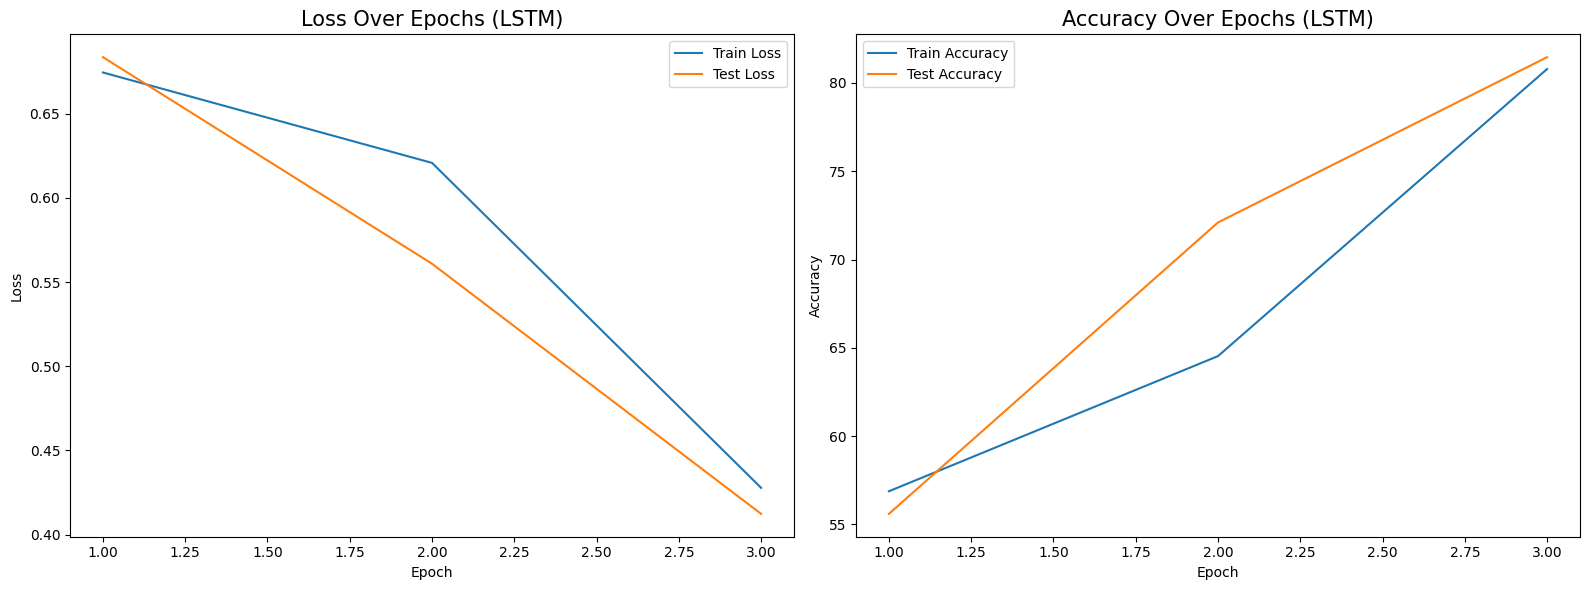

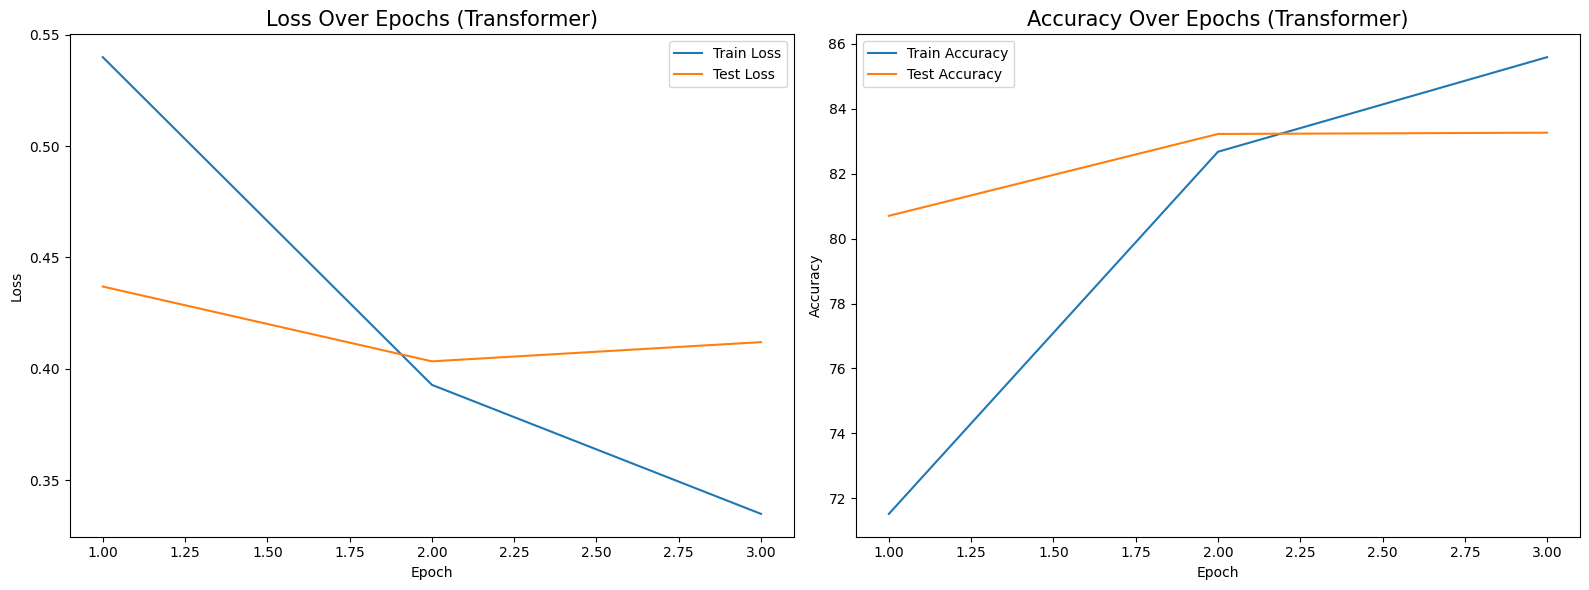

In [74]:
plot_performance("LSTM", N_EPOCHS, lstm_train_results, lstm_val_results)
plot_performance(
    "Transformer", N_EPOCHS, transformer_train_results, transformer_val_results
)

### Predictions on Test DataLoader

In [39]:
def make_predictions(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    accuracy: Accuracy,
    device: torch.device,
):
    all_predictions = []
    all_labels = []
    test_loss = 0.0
    total_samples = 0
    accuracy.reset()
    model.eval()
    with torch.inference_mode():
        for texts, labels in data_loader:
            texts, labels = texts.to(device), labels.to(device).unsqueeze(-1)

            # Forward pass
            y_logits = model(texts)
            y_probs = torch.sigmoid(y_logits)
            y_preds = (y_probs >= 0.5).int()

            # Calculate accuracy
            accuracy.update(y_preds, labels.int())

            # Update lists
            all_predictions.append(y_preds.cpu())
            all_labels.append(labels.cpu())

            # Calculate loss
            loss = criterion(y_logits.view_as(labels), labels)
            test_loss += loss.item() * texts.size(0)
            total_samples += texts.size(0)
    avg_test_loss = test_loss / total_samples
    test_acc = accuracy.compute().item() * 100
    print(f"Test loss: {avg_test_loss:.4f} | Test acc: {test_acc:.2f}%")
    all_preds_tensor = torch.cat(all_predictions)
    all_labels_tensor = torch.cat(all_labels)
    return all_preds_tensor, all_labels_tensor


In [40]:
print("Testing LSTM...")
all_preds_lstm, all_labels_lstm = make_predictions(
    model=lstm,
    data_loader=test_loader,
    criterion=criterion,
    accuracy=accuracy,
    device=device,
)

wrong_indices_lstm = (all_preds_lstm != all_labels_lstm).nonzero(as_tuple=True)[0]
print(
    f"Number of failed predictions: {len(wrong_indices_lstm)}/{len(all_labels_lstm)} ({100.0 * len(wrong_indices_lstm) / len(all_labels_lstm):.2f}%)"
)

Testing LSTM...
Test loss: 0.4000 | Test acc: 81.92%
Number of failed predictions: 904/5000 (18.08%)


In [41]:
print("Testing Transformer...")
all_preds_transformer, all_labels_transformer = make_predictions(
    model=transformer,
    data_loader=test_loader,
    criterion=criterion,
    accuracy=accuracy,
    device=device,
)

wrong_indices_transformer = (all_preds_transformer != all_labels_transformer).nonzero(
    as_tuple=True
)[0]
print(
    f"Number of failed predictions: {len(wrong_indices_transformer)}/{len(all_labels_transformer)} ({100.0 * len(wrong_indices_transformer) / len(all_labels_transformer):.2f}%)"
)

Testing Transformer...
Test loss: 0.4216 | Test acc: 82.58%
Number of failed predictions: 871/5000 (17.42%)


### Confusion Matrix

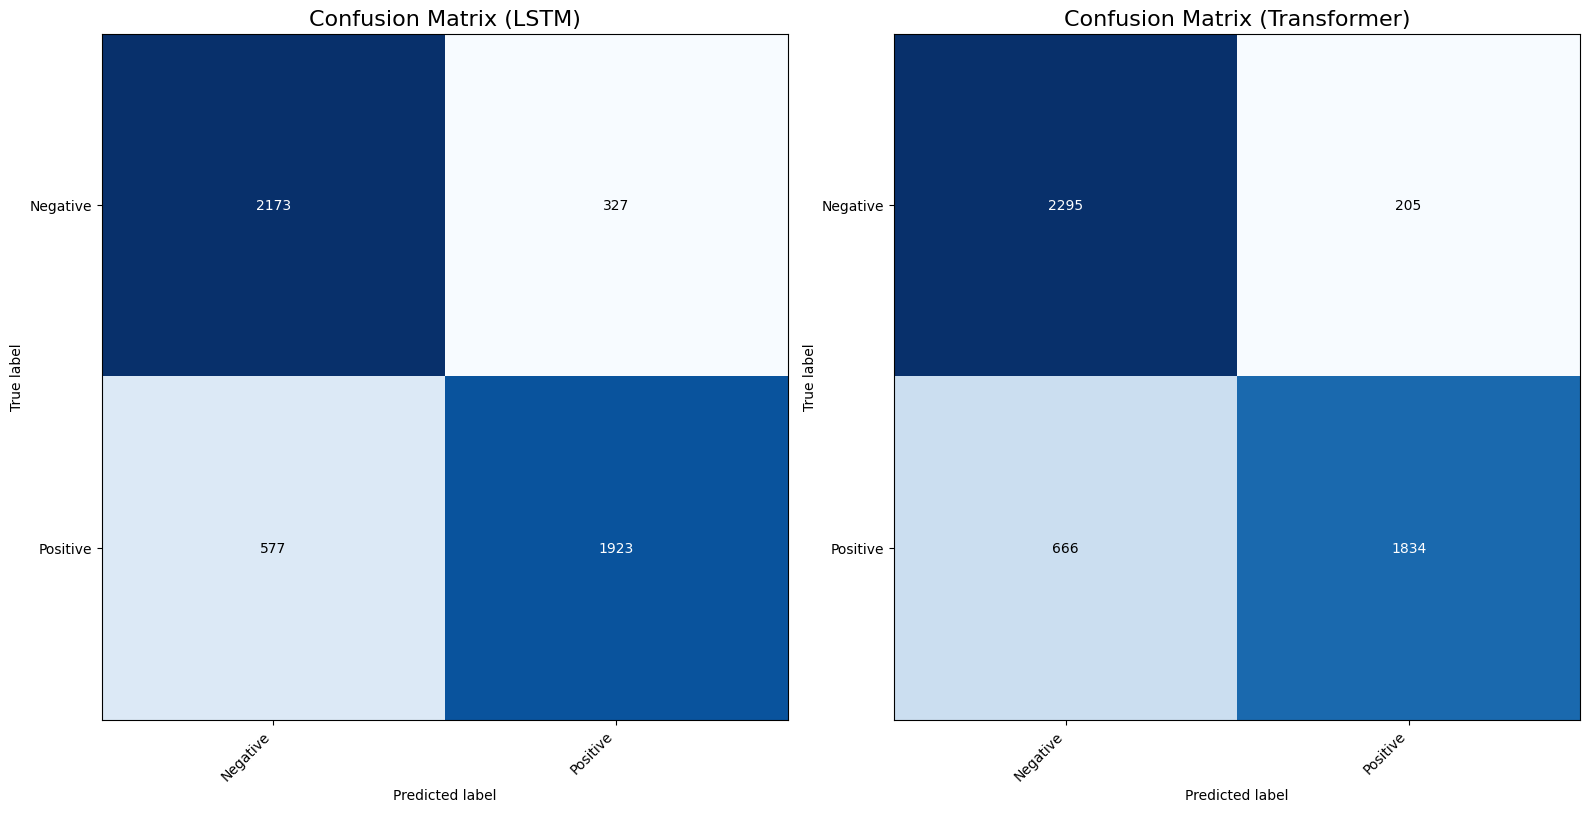

In [42]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Convert to tensors if not already
true_labels = all_labels_lstm
preds_tensor_lstm = all_preds_lstm.detach().clone()
preds_tensor_transformer = all_preds_transformer.detach().clone()
class_names = ["Negative", "Positive"]
model_names = ["LSTM", "Transformer"]

# Compute confusion matrix
conf_matrix = ConfusionMatrix(num_classes=2, task="binary")
conf_matrix_tensor_lstm = conf_matrix(preds_tensor_lstm, true_labels)
conf_matrix_tensor_transformer = conf_matrix(preds_tensor_transformer, true_labels)

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 10))
axes = axes.flatten()

plot_confusion_matrix(
    conf_mat=conf_matrix_tensor_lstm.numpy(),
    cmap="Blues",
    axis=axes[0],
)
plot_confusion_matrix(
    conf_mat=conf_matrix_tensor_transformer.numpy(),
    cmap="Blues",
    axis=axes[1],
)

for i, ax in enumerate(axes):
    ax.set_xticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticks(range(len(class_names)))
    ax.set_yticklabels(class_names)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(f"Confusion Matrix ({model_names[i]})", fontdict={"fontsize": 16})

plt.tight_layout()
plt.show()

### Sample Predictions

In [ ]:
def predict_single_text(
    model: torch.nn.Module,
    raw_text: str,
    word2index: dict[str, int],
    max_seq_len: int,
    device: torch.device,
) -> tuple[int, float]:
    """
    Predict the label and confidence score for a single raw text input using the given model.

    Args:
        model: The trained PyTorch model for classification.
        raw_text: The raw input string to classify.
        word2index: Mapping from token strings to their integer indices.
        max_seq_len: The fixed input sequence length for the model.
        device: The device on which to perform computation (CPU or GPU).

    Returns:
        Tuple:
            pred: Predicted class label (0 or 1).
            confidence: Confidence score between 0 and 1 indicating certainty about prediction.
    """
    model.eval()
    cleaned = clean_text(raw_text)
    tokens = cleaned.split()
    indices = [word2index.get(word, word2index["<UNK>"]) for word in tokens]
    if len(indices) < max_seq_len:
        indices += [word2index["<PAD>"]] * (max_seq_len - len(indices))
    else:
        indices = indices[:max_seq_len]
    input_tensor = torch.tensor([indices], dtype=torch.long).to(device)
    with torch.no_grad():
        logits = model(input_tensor)
        prob = torch.sigmoid(logits).item()
        pred = int(prob >= 0.5)
        confidence = abs(prob - 0.5) * 2
    return pred, confidence

In [44]:
text_1 = "I really enjoyed this movie! The storyline was engaging and the characters were well-developed. The visuals were stunning, and the soundtrack perfectly matched the mood. Definitely worth watching!"

pred_lstm, confidence_lstm = predict_single_text(
    lstm, text_1, word2index, SEQUENCE_LENGTH, device
)
pred_transformer, confidence_transformer = predict_single_text(
    transformer, text_1, word2index, SEQUENCE_LENGTH, device
)
class_map = {0: "Negative", 1: "Positive"}

print(f"Text: {text_1}\n")
print(
    f"LSTM:\t\t Predicted class: {pred_lstm}({class_map[pred_lstm]}), Confidence: {confidence_lstm:.3f}"
)
print(
    f"Transformer:\t Predicted class: {pred_transformer}({class_map[pred_transformer]}), Confidence: {confidence_transformer:.3f}"
)

Text: I really enjoyed this movie! The storyline was engaging and the characters were well-developed. The visuals were stunning, and the soundtrack perfectly matched the mood. Definitely worth watching!

LSTM:		 Predicted class: 1(Positive), Confidence: 0.951
Transformer:	 Predicted class: 1(Positive), Confidence: 0.575


In [45]:
text_2 = "I was quite disappointed by this movie. The story felt predictable and dull, the characters were underdeveloped, and the pacing was painfully slow. I struggled to stay interested and wouldn't recommend it."

pred_lstm, confidence_lstm = predict_single_text(
    lstm, text_2, word2index, SEQUENCE_LENGTH, device
)
pred_transformer, confidence_transformer = predict_single_text(
    transformer, text_2, word2index, SEQUENCE_LENGTH, device
)
class_map = {0: "Negative", 1: "Positive"}

print(f"Text: {text_2}\n")
print(
    f"LSTM:\t\t Predicted class: {pred_lstm}({class_map[pred_lstm]}), Confidence: {confidence_lstm:.3f}"
)
print(
    f"Transformer:\t Predicted class: {pred_transformer}({class_map[pred_transformer]}), Confidence: {confidence_transformer:.3f}"
)

Text: I was quite disappointed by this movie. The story felt predictable and dull, the characters were underdeveloped, and the pacing was painfully slow. I struggled to stay interested and wouldn't recommend it.

LSTM:		 Predicted class: 0(Negative), Confidence: 0.941
Transformer:	 Predicted class: 0(Negative), Confidence: 0.516


### Observations
After training for 3 epochs, the custom transformer model achieved a test accuracy of 82.58%, slightly outperforming the custom LSTM model, which reached 81.92% on the same test dataset. The test losses were 0.4216 for the transformer and 0.4000 for the LSTM, showing comparable performance.

However, when evaluating individual sample texts, the LSTM model predicted the sentiment with significantly higher confidence than the transformer model. For example:

- For a positive review, the LSTM returned a confidence of 0.951, compared to the transformer’s 0.575.

- For a negative review, the LSTM’s confidence was 0.941, compared to the transformer’s 0.516.

Although the transformer has a slightly better overall accuracy, the LSTM provides more decisive predictions (confidence scores closer to 1) on these specific examples.

The difference in confidence could be influenced by model architecture, training dynamics, or the calibration of output logits. Further fine-tuning, hyperparameter tuning, or a larger training dataset may be required to improve the transformer's confidence calibration.

## 12. Pre-Trained Transformer Model (From Hugging Face)
Hugging Face Transformers is an open-source library that simplifies the use of transformer architectures for diverse language tasks such as text classification, translation, summarization, question answering, and more. It offers pre-trained models that can be easily fine-tuned on specific datasets or used directly for inference, accelerating the development of NLP applications.

To use pre-trained transformer models from Hugging Face, the data preparation pipelines—from loading data to fine-tuning models—are commonly implemented using the datasets library, which provides efficient tools for loading, processing, and managing datasets.

In [46]:
from datasets import load_dataset

dataset = load_dataset(
    path="csv",
    data_files={"all_data": "_datasets/IMDB_Dataset.csv"},
)

dataset = dataset.rename_column("sentiment", "labels")

In the original dataset, sentiment labels are stored as strings ('positive' or 'negative'). To process the data for Hugging Face transformers, these labels should be converted to integer values.

In [ ]:
def label_to_int(sample: dict) -> dict:
    """
    Convert string sentiment labels ('positive'/'negative') to integer labels (1/0).

    Args:
        sample: A dictionary representing a data example with a 'labels' key.

    Returns:
        Dict: The same dictionary with 'labels' converted to integer values.
    """

    if sample["labels"] == "positive":
        sample["labels"] = 1
    else:
        sample["labels"] = 0
    return sample


# Apply it on the full dataset
dataset = dataset.map(label_to_int)

The dataset is split into training, validation, and test subsets. To accelerate the training process, 10000 samples are randomly selected from the full dataset of 50000 samples.

In [58]:
# 80% train, 10% validation and 10% test
split = (
    dataset["all_data"]
    .shuffle(seed=RANDOM_SEED)
    .select(range(10000))
    .train_test_split(test_size=0.2, seed=RANDOM_SEED)
)
train_dataset = split["train"]
subset = split["test"]

subset_split = subset.train_test_split(test_size=0.5, seed=RANDOM_SEED)
val_dataset = subset_split["train"]
test_dataset = subset_split["test"]

### Tokenisation with Hugging Face
Tokenise the text using the pre-trained tokeniser with padding and truncation.

In [ ]:
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokeniser = AutoTokenizer.from_pretrained(model_name)


def tokenise(batch: dict) -> dict:
    """
    Tokenise a batch of text data using a tokeniser.

    Args:
        batch: A batch dictionary with key 'review' containing text string(s).

    Returns:
        Tokenised output including token ids, attention mask, etc.
    """
    return tokeniser(
        batch["review"],
        padding="max_length",
        truncation=True,
    )

In [60]:
tokenised_train_dataset = train_dataset.map(tokenise, batched=True)
tokenised_val_dataset = val_dataset.map(tokenise, batched=True)
tokenised_test_dataset = test_dataset.map(tokenise, batched=True)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [61]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokeniser)

### Reformatting for PyTorch
Format the dataset for PyTorch, including the labels column as integer tensor.

In [62]:
tokenised_train_dataset.set_format(
    "torch", columns=["input_ids", "attention_mask", "labels"]
)
tokenised_val_dataset.set_format(
    "torch", columns=["input_ids", "attention_mask", "labels"]
)
tokenised_test_dataset.set_format(
    "torch", columns=["input_ids", "attention_mask", "labels"]
)

### Training Arguments

In [63]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # Evaluate after each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir="./logs",
)

### Metrics

In [ ]:
import evaluate

metric = evaluate.load("accuracy")


def compute_metrics(
    eval_pred: tuple[NDArray[np.float64], NDArray[np.int64]],
) -> dict[str, float]:
    """
    Compute evaluation metrics for model outputs and true labels.

    Args:
        eval_pred: Tuple containing raw model logits and target labels.
            - logits: Array of shape (batch_size, num_classes)
            - labels: Array of shape (batch_size,)

    Returns:
        Dictionary of computed metric scores, e.g., {'accuracy': 0.95}.
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

### Loading Pre-Trained Model

In [65]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [66]:
from transformers import AutoModelForSequenceClassification

num_labels = 2  # Binary Classification
hf_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training Transformer Model

In [67]:
from transformers import Trainer

trainer = Trainer(
    model=hf_model,
    args=training_args,
    train_dataset=tokenised_train_dataset,
    eval_dataset=tokenised_val_dataset,
    processing_class=tokeniser,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.304100,0.214928,0.918000
2,0.163500,0.287378,0.923000
3,0.089000,0.325328,0.921000


/Users/tsu76i/Documents/Programming/Personal Projects/DS_Projects/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/tsu76i/Documents/Programming/Personal Projects/DS_Projects/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=1500, training_loss=0.18554996744791666, metrics={'train_runtime': 3306.53, 'train_samples_per_second': 7.258, 'train_steps_per_second': 0.454, 'total_flos': 3179217567744000.0, 'train_loss': 0.18554996744791666, 'epoch': 3.0})

In [68]:
trainer.save_model("./my_finetuned_model")
tokeniser.save_pretrained("./my_finetuned_model")

('./my_finetuned_model/tokenizer_config.json',
 './my_finetuned_model/special_tokens_map.json',
 './my_finetuned_model/vocab.txt',
 './my_finetuned_model/added_tokens.json',
 './my_finetuned_model/tokenizer.json')

In [69]:
# Evaluate on test set
metrics = trainer.evaluate(tokenised_test_dataset)
print(metrics)

/Users/tsu76i/Documents/Programming/Personal Projects/DS_Projects/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.23493066430091858, 'eval_accuracy': 0.912, 'eval_runtime': 38.6308, 'eval_samples_per_second': 25.886, 'eval_steps_per_second': 1.631, 'epoch': 3.0}


Despite being trained on only 20% of the full dataset, the fine-tuned transformer achieved a test accuracy of 91.2%.

### Predictions with Fine-Tuned Model
After training, the fine-tuned model and tokeniser can be used to predict the label and confidence score of a single text sample.

In [70]:
import torch.nn.functional as F

MY_MODEL_PATH = "./my_finetuned_model"
my_tokeniser = AutoTokenizer.from_pretrained(MY_MODEL_PATH)
my_model = AutoModelForSequenceClassification.from_pretrained(MY_MODEL_PATH)

inputs = my_tokeniser(text_1, return_tensors="pt")
with torch.no_grad():
    logits = my_model(**inputs).logits
    # Apply softmax to get probabilities for each class
    probabilities = F.softmax(logits, dim=-1)
    confidence = probabilities.max().item()  # Probability of the predicted class
    predicted_class_id = probabilities.argmax().item()

print(f"Text: {text_1}")
print(
    f"Predicted: {predicted_class_id} ({my_model.config.id2label[predicted_class_id]}), Confidence: {confidence:.4f}\n"
)

Text: I really enjoyed this movie! The storyline was engaging and the characters were well-developed. The visuals were stunning, and the soundtrack perfectly matched the mood. Definitely worth watching!
Predicted: 1 (POSITIVE), Confidence: 0.9891



In [71]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model=MY_MODEL_PATH)
print(f"Text: {text_1}")
print(classifier(text_1))
print(f"\nText: {text_2}")
print(classifier(text_2))

Device set to use mps:0


Text: I really enjoyed this movie! The storyline was engaging and the characters were well-developed. The visuals were stunning, and the soundtrack perfectly matched the mood. Definitely worth watching!
[{'label': 'POSITIVE', 'score': 0.9891244173049927}]

Text: I was quite disappointed by this movie. The story felt predictable and dull, the characters were underdeveloped, and the pacing was painfully slow. I struggled to stay interested and wouldn't recommend it.
[{'label': 'NEGATIVE', 'score': 0.9897481203079224}]


If the `model` parameter is not specified, the pipeline will automatically download and load the default pre-trained model for sentiment analysis, which is currently `"distilbert-base-uncased-finetuned-sst-2-english"`.

This default model is a smaller, distilled version of BERT fine-tuned on the SST-2 sentiment dataset, providing quick and effective sentiment classification out-of-the-box.

In [76]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
print(f"\nText: {text_1}")
print(classifier(text_1))
print(f"\nText: {text_2}")
print(classifier(text_2))

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Device set to use mps:0



Text: I really enjoyed this movie! The storyline was engaging and the characters were well-developed. The visuals were stunning, and the soundtrack perfectly matched the mood. Definitely worth watching!
[{'label': 'POSITIVE', 'score': 0.999881386756897}]

Text: I was quite disappointed by this movie. The story felt predictable and dull, the characters were underdeveloped, and the pacing was painfully slow. I struggled to stay interested and wouldn't recommend it.
[{'label': 'NEGATIVE', 'score': 0.9998039603233337}]


## 13. References

1. Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A.N., Kaiser, L., Polosukhin, I. (2017). *Attention Is All You Need.* arXiv preprint arXiv:1706.03762.<br>
https://arxiv.org/abs/1706.03762

1. Cole Stryker, Dave Bergmann. (2025). What is a transformer model?<br>
https://www.ibm.com/think/topics/transformer-model

1. Daniel Melchor. (2021). *A detailed guide to Pytorch’s nn.Transformer() module.*<br>
https://towardsdatascience.com/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1/

1. Evren Ozkip. (2023). *Text Classification with Transformers using IMDB*.<br>
https://www.kaggle.com/code/tirendazacademy/text-classification-with-transformers-using-imdb

1. Gruhesh Sri Sai Karthik Kurra. (2025). *Building a Sentiment Analysis Model with LSTMs in PyTorch*.
https://dev.to/gruhesh_kurra_6eb933146da/building-a-sentiment-analysis-model-with-lstms-in-pytorch-468p

1. Hugging Face. (n.d.). *Fine-tuning*.<br>
https://huggingface.co/docs/transformers/training

1. Hugging Face. (n.d.). *Text classification*.<br>
https://huggingface.co/docs/transformers/tasks/sequence_classification

1. Hugging Face. (n.d.). *Trainer*.<br>
https://huggingface.co/docs/transformers/trainer

1. Mikayla Gawarecki. (2024). *Accelerating PyTorch Transformers by replacing nn.Transformer with Nested Tensors and torch.compile()*.<br>
https://docs.pytorch.org/tutorials/intermediate/transformer_building_blocks.html

1. Pawan Sharma. (2021). *IMBD sentiment Analysis using Pytorch-LSTM*.<br>
https://www.kaggle.com/code/pawan2905/imbd-sentiment-analysis-using-pytorch-lstm/notebook

1. PyTorch Docs. (n.d.). *Transformers*.<br>
https://docs.pytorch.org/docs/stable/generated/torch.nn.Transformer.html